# Compare inside and outside AGD-HFM-Pykasso integration #

In [1]:
#General imports
import os            
import sys           
import importlib
import numpy as np
from matplotlib import pyplot as plt

#all fast-marching-related imports
import agd
from agd import Eikonal
#from agd.Metrics import Riemann
#from agd.Plotting import quiver
#from agd import LinearParallel as lp
#from agd import AutomaticDifferentiation as ad
#norm_infinity = ad.Optimization.norm_infinity

#pykasso import
sys.path.append('C:/Users/Chloe/Documents/GitHub/pyKasso/pykasso') #path to local version of package
import base as pk  #in this case, "base" is the name of the .py file with all of the pykasso functions in it

In [2]:
os.getcwd()

'C:\\Users\\Chloe\\Documents\\GitHub\\pyKasso\\notebooks'

## Geology & topography ##
Choose either "Generate from scratch" or "Load from files" and run that cell, not both

### Generate from scratch ###

flat DEM array: (80, 100) 600.0 600.0
DEM array: (80, 100) 252.5 600.0
Geology array: (80, 100) 1 2
Cost array: (80, 100) 0.4 0.9


Text(0.5, 0, 'Cost array')

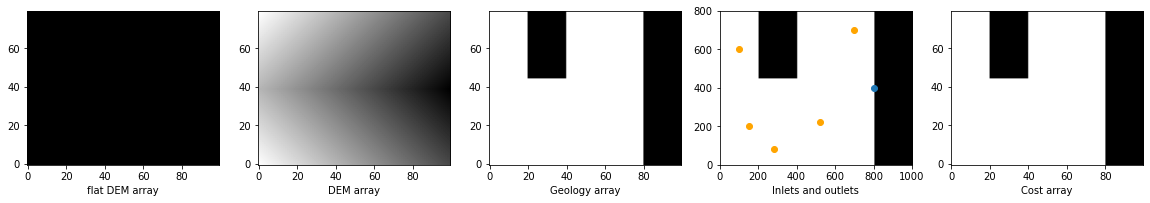

In [85]:
#Define grid:
xmin = 0;  xmax = 1000;  xres = 100;  dx = 10.0 
ymin = 0;  ymax = 800;   yres = 80;   dy = 10.0 
zmin = 0;  zmax = 600;   zres = 60;   dz = 10.0

#Create 2D flat topography array for comparison:
flat = np.full((xres,yres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z index
flat = np.rot90(flat)
print('flat DEM array:', flat.shape, flat.min(), flat.max())    #print dimensions
np.savetxt("inputs/fresh/flat.csv", flat, delimiter=',')  #export as csv
f = plt.figure(figsize=(20,5))
f.add_subplot(151, aspect='equal')
plt.imshow(flat, origin='lower', cmap='gray') #darker=lower 
plt.xlabel('flat DEM array')

#Create 2D topography array:
dem = np.full((xres,yres),zmax, dtype=float) #create array with the model x and y dimensions, filled with the max z index
mx = -0.25 * dx                     #set the slope in the x direction (west to east)
my = -0.25 * dy                     #set the slope in the y direction (north to south)
valley  = yres//2                   #set which row to put the valley in
for ix in range(xres):               #move west to east along x indices (columns)
    dem[ix,:] = mx*ix + dem[0,0]     #change the elevation in each column along a slope, starting from the max elevation
    for iy in range(0,valley+1):     #move down rows towards valley (north to south)
        dem[ix,iy] = my*iy + dem[ix,0]   #change the elevation in each row along a slope, starting from the elevation along the northern edge
for iy in range(valley,yres):            #move down y indices (rows) away from valley (south to north)
    dem[:,iy] = dem[:,yres-iy]           #insert a mirror image of the north side of the valley
dem = np.rot90(dem)
print('DEM array:', dem.shape, dem.min(), dem.max())    #print dimensions
np.savetxt("inputs/fresh/dem.csv", dem, delimiter=',')  #export as csv
f.add_subplot(152, aspect='equal')
plt.imshow(dem, origin='lower', cmap='gray') #darker=lower 
plt.xlabel('DEM array')

#Create 2D geology array:
limestone = 1
shale     = 2
geo = np.full((xres,yres), limestone)   #set 3D array of model dimensions filled with limestone value
geo[20:40, 0:35] = shale                #insert a block of shale in one corner to make array asymmetrical
geo[80:]        = shale                 #make one end shale
geo = np.rot90(geo)
print('Geology array:', geo.shape, geo.min(), geo.max())   
np.savetxt("inputs/fresh/geo.csv", geo, delimiter=',')  #export as csv
f.add_subplot(153, aspect='equal')
plt.imshow(geo, origin='lower', cmap='gray_r') #white = limestone
plt.xlabel('Geology array')

#Define inlets and outlets:
inlets  = np.asarray([[100,600],[150,200],[520,220],[280,80],[700,700]])
outlets = np.asarray([[800,400]])
np.savetxt("inputs/fresh/inlets.csv",  inlets,  delimiter=',')  #export as csv
np.savetxt("inputs/fresh/outlets.csv", outlets, delimiter=',')  #export as csv
f.add_subplot(154, aspect='equal')
plt.imshow(geo, origin='lower', extent =[xmin,xmax,ymin,ymax], cmap='gray_r') #white = limestone
plt.xlabel('Inlets and outlets')
plt.scatter(inlets[:,0],  inlets[:,1], c='orange')
plt.scatter(outlets[:,0], outlets[:,1])

#Set up the cost field:
Ckarst    = 0.4    #travel cost in karstifiable unit (should be low)
Cnonkarst = 0.9    #travel cost in nonkarst unit (should be high)
Cconduit  = 0.1   #travel cost in conduits (should be low)
cost = np.full((xres,yres), Ckarst)    #set up array of default cost values (must be rotated 90 degrees to match geo array)
cost = np.rot90(cost)
cost[geo==1] = Ckarst     #assign low cost to limestone (2)
cost[geo==2] = Cnonkarst  #assign medium-high cost to all non-karst units
print('Cost array:', cost.shape, cost.min(), cost.max())    #print dimensions
np.savetxt("inputs/fresh/cost.csv", cost, delimiter=',')  #export as csv
f.add_subplot(155, aspect='equal')
plt.imshow(cost, origin='lower', cmap='gray_r') #darker=higher cost
plt.xlabel('Cost array')

### Load from files ###

DEM array: (80, 100) 252.5 600.0
Geology array: (80, 100) 2.0 3.0


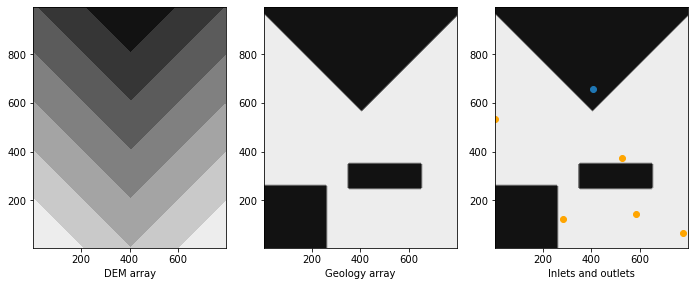

In [11]:
#Define grid:
xmin = 0;  xmax = 1000;  xres = 100;  dx = 10.0 
ymin = 0;  ymax = 800;   yres = 80;   dy = 10.0 
zmin = 0;  zmax = 600;   zres = 60;   dz = 10.0

# Define grid for the model object:
hfmIn = agd.Eikonal.dictIn({
    'model':             'Riemann2', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':              2,         #recommended setting: 2
    'exportValues':       1,         #output travel time field
    'exportGeodesicFlow': 1          #output walker paths
})
hfmIn.SetRect(sides=[[ymin,ymax],[xmin,xmax]],dims=[yres,xres])  #hfm library grid is flipped
X,Y = hfmIn.Grid()  #get model grid
f = plt.figure(figsize=(20,5)) #create blank figure

#2D topography array:
dem = np.genfromtxt("inputs/valley1/dem80x100.csv", delimiter=',')  #export as csv
print('DEM array:', dem.shape, dem.min(), dem.max())    #print dimensions
f.add_subplot(152, aspect='equal')
#plt.imshow(dem, origin='lower', cmap='gray') #darker=lower 
plt.contourf(X,Y, dem, cmap='gray') #darker=lower 
plt.xlabel('DEM array')

#2D geology array:
geo = np.genfromtxt("inputs/valley1/geo80x100.csv", delimiter=',')  #export as csv
print('Geology array:', geo.shape, geo.min(), geo.max())   
f.add_subplot(153, aspect='equal')
#plt.imshow(geo, origin='lower', cmap='gray_r') #white = limestone
plt.contourf(X,Y, geo, cmap='gray_r')  
plt.xlabel('Geology array')

#Inlets and outlets:
inlets  = np.genfromtxt("inputs/valley1/inlets.txt",  delimiter=' ')  #import as csv
outlets = np.asarray([np.genfromtxt("inputs/valley1/outlets.txt", delimiter=' ')])  #import as csv - have to wrap in an array if only a single value, otherwise indexing won't work
try:
    inlets  = inlets[:,:2] #drop z value
    outlets = outlets[:,:2] #drop z value
except:
    pass
f.add_subplot(154, aspect='equal')
#plt.imshow(geo, origin='lower', extent =[xmin,xmax,ymin,ymax], cmap='gray_r') #white = limestone
plt.contourf(X,Y, geo, cmap='gray_r')
plt.xlabel('Inlets and outlets')
plt.scatter(inlets[:,1],  inlets[:,0], c='orange')
plt.scatter(outlets[:,1], outlets[:,0])



## Fast Marching outside of PyKasso ###

Cost array: (80, 100) 0.3 0.8


Text(0.5, 0, 'Cost array')

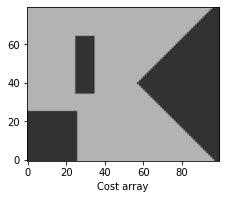

In [12]:
#Assign cost values
Cout      = 0.999  #travel cost in areas outside model bound (should be very high)
Ckarst    = 0.3    #travel cost in karstifiable unit (should be low)
#Cnonkarst = 0.6    #travel cost in nonkarst unit (should be high)
Cnonkarst = 0.8   #changed to be higher based on Test #3
Cfracture = 0.2   #travel cost in fractures
Cconduit  = 0.1   #travel cost in conduits (should be low)

#Assign cost values to array based on geology:
cost = np.full(geo.shape, Ckarst) #set up array of default alpha values
cost[np.isnan(geo)] = Cout        #assign very high cost to out of bounds
cost[geo==2]        = Ckarst      #assign low cost to limestone (2)
cost[geo!=2]        = Cnonkarst   #assign medium-high cost to all non-karst units
#cost[fractures==1]  = Cfracture  #assign lower cost to fractures 

#Plot:
f = plt.figure(figsize=(20,5)) #create blank figure
print('Cost array:', cost.shape, cost.min(), cost.max())    #print dimensions
f.add_subplot(155, aspect='equal')
plt.imshow(cost, origin='lower', cmap='gray_r', vmin=0,vmax=1) #darker=higher cost
#plt.contourf(X,Y, cost, cmap='gray_r', vmin=0, vmax=1) 
plt.xlabel('Cost array')

### One iteration ###

X shape (80, 100) Y shape (80, 100)
dims [ 80. 100.]
dem shape (80, 100)
cost shape (80, 100)
alpha shape (80, 100)
DxV shape (80, 100) DyV shape (80, 100)
DxV values [-0.25  0.    0.25] DyV values [-0.25]
F shape (80, 100)
outlets [[405. 655.]]
inlets [[  5. 535.]
 [525. 375.]
 [285. 125.]
 [585. 145.]
 [775.  65.]]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
time shape (80, 100)


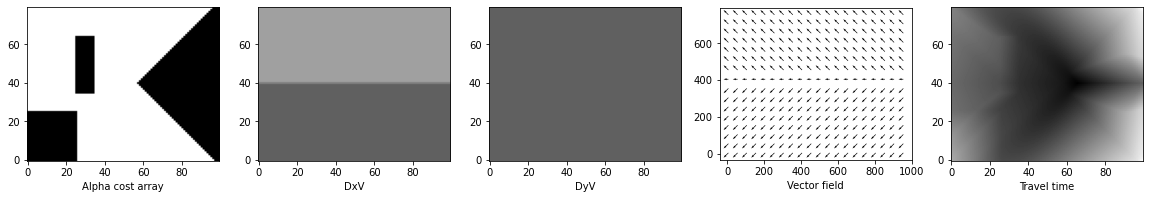

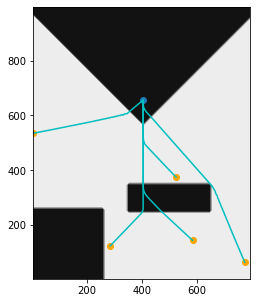

In [13]:
pkgrid = True   #match grid system used in pykass0
rot90 = False   #manually rotate arrays
verbosity = 1

# Create a model object and define the domain:
hfmIn = agd.Eikonal.dictIn({
    'model':             'Riemann2', #three-dimensional Riemannian eikonal equation (for 2D: Riemann2, for isotropic: Isotropic2 or 3)
    'order':              2,         #recommended setting: 2
    'exportValues':       1,         #output travel time field
    'exportGeodesicFlow': 1          #output walker paths
})
if rot90 == True:
    hfmIn.SetRect(sides=[[ymin,ymax],[xmin,xmax]],dims=[yres,xres])
    Y,X = hfmIn.Grid()  #get model grid
elif pkgrid == True:
    hfmIn.SetRect(sides=[[ymin,ymax],[xmin,xmax]],dims=[yres,xres])
    Y,X = hfmIn.Grid()  #get model grid
else:
    hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax]],dims=[xres,yres])
    X,Y = hfmIn.Grid()  #get model grid
if verbosity > 0:
    print('X shape', X.shape, 'Y shape', Y.shape)
    #print(X); print(Y)
    print('dims', hfmIn['dims'])

#Calculate the gradients:
if rot90 == True:
    DxV,DyV = np.gradient(dem,                 dx,dy, axis=(0,1))   #x and y components of gradient in each cell of array
    DxV = np.flipud(np.rot90(DxV))
    DyV = np.flipud(np.rot90(DyV))
    alpha = np.flipud(np.rot90(cost))             #travel cost in same direction as gradient
elif pkgrid == True:
    DxV,DyV = np.gradient(dem,                 dx,dy, axis=(0,1))   #x and y components of gradient in each cell of array
    alpha = cost                               #travel cost in same direction as gradient
else:
    DxV,DyV = np.gradient(dem,                 dx,dy, axis=(0,1,))   #x and y components of gradient in each cell of array 
    alpha = cost             #travel cost in same direction as gradient

if verbosity > 0: 
    print('dem shape',   dem.shape)
    print('cost shape',  cost.shape)
    print('alpha shape', alpha.shape)
    print('DxV shape',   DxV.shape, 'DyV shape', DyV.shape)
    print('DxV values',  np.unique(DxV), 'DyV values', np.unique(DyV))

Cratio = 0.25                       #ratio of travel cost parallel to gradient / perpendicular to gradient
beta  = alpha / Cratio      #travel cost perpendicular to gradient (should be higher than parallel cost) 
if rot90 == True:
    F = agd.Metrics.Riemann.needle([DyV,DxV], alpha,beta)  #convert gradient fields to hfm format & incorporate travel costs
elif pkgrid == True:
    F = agd.Metrics.Riemann.needle([DxV,DyV], alpha,beta) 
else:
    F = agd.Metrics.Riemann.needle([DxV,DyV], alpha,beta)  #convert gradient fields to hfm format & incorporate travel costs
hfmIn['metric'] = F  #set the travel cost through each cell
if verbosity > 0:
    print('F shape', F.shape)

#Set the inlets and outlets
if rot90 == True:
    hfmIn['seeds']  = outlets[:,[1,0]]    #set the spring coordinates (need to change iteration structure to do one spring at a time)
    hfmIn['tips']   = inlets[ :,[1,0]]    #set the inlet coordinates 
elif pkgrid == True:
    hfmIn['seeds']  = outlets[:,[1,0]]    #set the spring coordinates (need to change iteration structure to do one spring at a time)
    hfmIn['tips']   = inlets[ :,[1,0]]    #set the inlet coordinates 
else:
    hfmIn['seeds']  = outlets   #set the spring coordinates (need to change iteration structure to do one spring at a time)
    hfmIn['tips']   = inlets    #set the inlet coordinates 
if verbosity > 0:
    print('outlets', hfmIn['seeds'])
    print('inlets',  hfmIn['tips'])

#Run
hfmOut = hfmIn.Run()
time   = hfmOut['values']
#time = np.rot90(hfmOut['values'])
paths = hfmOut['geodesics']
if verbosity > 0:
    print('time shape', time.shape)

#Plot
f = plt.figure(figsize=(20,5))
f.add_subplot(151, aspect='equal')
plt.xlabel('Alpha cost array')
plt.imshow(alpha, origin='lower', cmap='gray_r') #darker=faster
#plt.contourf(X,Y, cost, cmap='gray_r')
f.add_subplot(152, aspect='equal')
plt.xlabel('DxV')
plt.imshow(DxV, origin='lower', cmap = 'gray', vmin=-1, vmax=1)
#plt.contourf(X,Y, DxV, cmap = 'gray', vmin=-1, vmax=1)
f.add_subplot(153, aspect='equal')
plt.xlabel('DyV')
plt.imshow(DyV, origin='lower', cmap='gray', vmin=-1,vmax=1)
#plt.contourf(X,Y, DyV, cmap = 'gray', vmin=-1,vmax=1)
f.add_subplot(154, aspect='equal')
plt.xlabel('Vector field')
skip=(slice(None,None,5),slice(None,None,5))
if pkgrid == True:
    plt.quiver(X[skip], Y[skip], DyV[skip], DxV[skip], scale=10)
else:
    plt.quiver(Y[skip], X[skip], DyV[skip], DxV[skip], scale=10)
f.add_subplot(155, aspect='equal')
plt.xlabel('Travel time')
plt.imshow(time, origin='lower', cmap='gray') #darker=faster
#plt.contourf(X,Y, time, cmap='gray')
f = plt.figure(figsize=(5,5))
f.add_subplot(111, aspect='equal')
plt.contourf(Y,X, alpha, cmap='gray_r')
if rot90 == True:
    plt.scatter(hfmIn['tips'][:,0],  hfmIn['tips'][:,1], c='orange')
    plt.scatter(hfmIn['seeds'][:,0], hfmIn['seeds'][:,1])
    for path in paths:                                  #loop over paths (one per tip/starting point)
        pathX = path[0,:]                               #get list of X coord
        pathY = path[1,:]
        plt.plot(pathX,pathY, c='c')
elif pkgrid == True:
    plt.scatter(hfmIn['tips'][:,0],  hfmIn['tips'][:,1], c='orange')
    plt.scatter(hfmIn['seeds'][:,0], hfmIn['seeds'][:,1])
    for path in paths:                                  #loop over paths (one per tip/starting point)
        pathX = path[0,:]                               #get list of X coord
        pathY = path[1,:]
        plt.plot(pathX,pathY, c='c')
else:
    plt.scatter(hfmIn['tips'][:,1],  hfmIn['tips'][:,0], c='orange')
    plt.scatter(hfmIn['seeds'][:,1], hfmIn['seeds'][:,0])
    for path in paths:                                  #loop over paths (one per tip/starting point)
        pathX = path[1,:]                               #get list of X coord
        pathY = path[0,:]
        plt.plot(pathX,pathY, c='c')

### Iterate over inlets ###

icost shape (80, 100, 5)
0 [535.   5.]
DxV (80, 100) [-0.25  0.    0.25]
DyV (80, 100) [-0.25]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
1 [375. 525.]
DxV (80, 100) [-0.25  0.    0.25]
DyV (80, 100) [-0.25]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.01 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
2 [125. 285.]
DxV (80, 100) [-0.25  0.    0.25]
DyV (80, 100) [-0.25]
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults

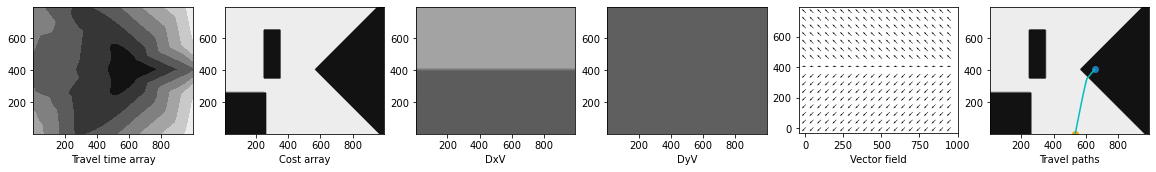

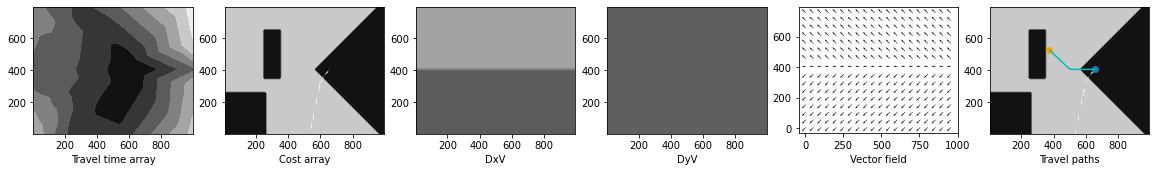

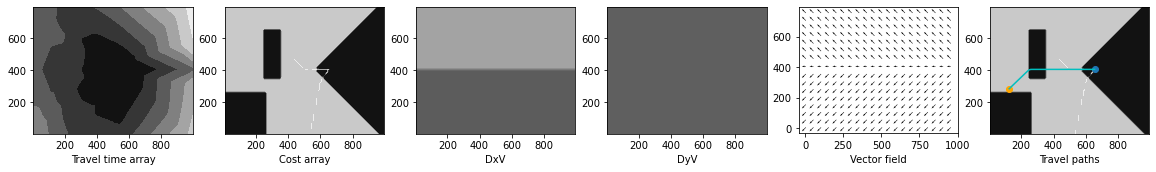

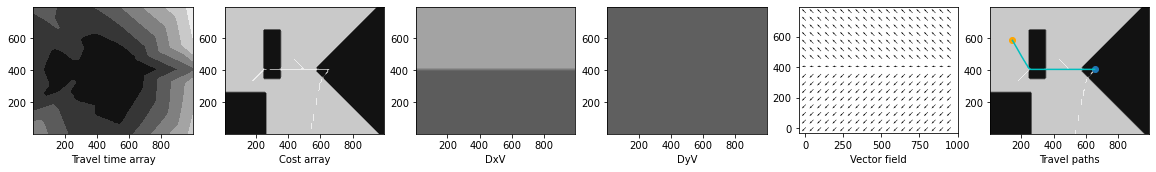

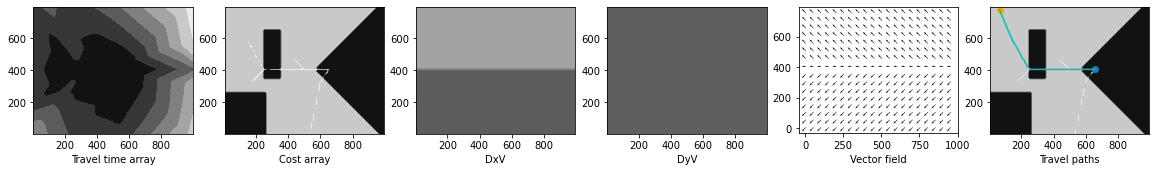

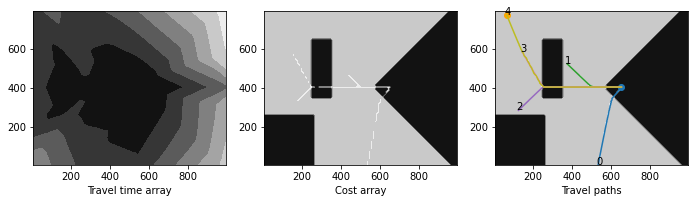

In [14]:
#2D with multiple iterations
pkgrid = True
rot90 = False
verbosity = 1
#inlets  = tips[:,:2]
#outlets = springs[:,:2]
#dem     = dema
costmap = cost
X2 = X
Y2 = Y

icost   = np.repeat(cost[:,:,np.newaxis], len(inlets), axis=2)  #repeat cost arrays for each iteration
print('icost shape', icost.shape)
network = []
for i,inlet in enumerate(inlets):
    print(i,inlet)
    # Create a model object and define the domain:
    if rot90 == True:
        hfmIn.SetRect(sides=[[ymin,ymax],[xmin,xmax]],dims=[yres,xres])
        Y,X = hfmIn.Grid()  #get model grid
    elif pkgrid == True:
        hfmIn.SetRect(sides=[[ymin,ymax],[xmin,xmax]],dims=[yres,xres])
        Y,X = hfmIn.Grid()  #get model grid
    else:
        hfmIn.SetRect(sides=[[xmin,xmax],[ymin,ymax]],dims=[xres,yres])
        X,Y = hfmIn.Grid()  #get model grid
    if verbosity > 1:
        print('X shape', X.shape, 'Y shape', Y.shape)
        print(X); print(Y)
        
    #Calculate the gradients:
    if rot90 == True:
        DxV,DyV = np.gradient(dem,                 dx,dy, axis=(0,1))   #x and y components of gradient in each cell of array
        DxV = np.flipud(np.rot90(DxV))
        DyV = np.flipud(np.rot90(DyV))
        alpha = np.flipud(np.rot90(icost[:,:,i]))             #travel cost in same direction as gradient
    elif pkgrid == True:
        DxV,DyV = np.gradient(dem,                 dx,dy, axis=(0,1))   #x and y components of gradient in each cell of array
        alpha = icost[:,:,i]                               #travel cost in same direction as gradient
    else:
        DxV,DyV = np.gradient(dem,                 dx,dy, axis=(0,1,))   #x and y components of gradient in each cell of array 
        #DxV,DyV = np.gradient(np.rot90(flat,k=-1), dx,dy, axis=(0,1,))   #x and y components of gradient in each cell of array 
        #DxV,DyV = np.gradient(np.rot90(dem, k=-1), dx,dy, axis=(0,1,))   #x and y components of gradient in each cell of array 
        alpha = icost[:,:,i]             #travel cost in same direction as gradient (choose cost for this iteration)
    if verbosity > 0:
        print('DxV', DxV.shape, np.unique(DxV))
        print('DyV', DyV.shape, np.unique(DyV))
        
    Cratio = 0.25                       #ratio of travel cost parallel to gradient / perpendicular to gradient
    beta  = alpha / Cratio      #travel cost perpendicular to gradient (should be higher than parallel cost) 
    if rot90 == True:
        F = agd.Metrics.Riemann.needle([DyV,DxV], alpha,beta)  #convert gradient fields to hfm format & incorporate travel costs
    elif pkgrid == True:
        F = agd.Metrics.Riemann.needle([DxV,DyV], alpha,beta)
    else:
        F = agd.Metrics.Riemann.needle([DxV,DyV], alpha,beta)  #convert gradient fields to hfm format & incorporate travel costs
    hfmIn['metric'] = F  #set the travel cost through each cell
    if verbosity > 1:
        print('F', F.shape, np.unique(F))
    
   #Set the inlets and outlets
    if rot90 == True:
        hfmIn['seeds']  = outlets[:,[1,0]]    #set the spring coordinates (need to change iteration structure to do one spring at a time)
        hfmIn['tip']    = inlet[[1,0]]    #set the inlet coordinates 
    elif pkgrid == True:
        hfmIn['seeds']  = outlets[:,[1,0]]    #set the spring coordinates (need to change iteration structure to do one spring at a time)
        hfmIn['tip']    = inlet[[1,0]]    #set the inlet coordinates 
    else:
        hfmIn['seeds']  = outlets   #set the spring coordinates (need to change iteration structure to do one spring at a time)
        hfmIn['tip']    = inlet    #set the inlet coordinates 
        
    #Run & get outputs:
    hfmOut = hfmIn.Run()
    #time = np.rot90(hfmOut['values'])
    time = hfmOut['values']
    paths = hfmOut['geodesics']
    network.append(paths)
    
    #Update cost array to have lower cost in conduits:
    if i < len(inlets)-1:
        for path in paths:                     #loop over paths (if more than one per iteration)
            for p in range(path.shape[1]):     #loop over XYZ coordinates of each point in path (have to index to loop over second dimension)
                point = path[:,p]          
                [[ix,iy],error]  = hfmIn.IndexFromPoint(point) #convert to indices
                if rot90 == True:
                    icost[iy,ix,i+1:] = Cconduit   #assign a new cost value to cells with conduits in them for next iteration
                elif pkgrid == True:
                    icost[ix,iy,i+1:] = Cconduit
                else:
                    icost[ix,iy,i+1:] = Cconduit   #assign a new cost value to cells with conduits in them for next iteration
    
    #Plot
    f = plt.figure(figsize=(20,5))
    f.add_subplot(161, aspect='equal')
    plt.xlabel('Travel time array')
    #plt.imshow(time, origin='lower', cmap='gray') #darker=faster
    plt.contourf(X,Y,time, cmap='gray')
    
    f.add_subplot(162, aspect='equal')
    plt.xlabel('Cost array')
    #plt.imshow(icost[:,:,i], origin='lower', cmap='gray_r') #darker=higher cost
    #plt.contourf(X,Y, icost[:,:,i], cmap='gray_r') 
    plt.contourf(X,Y,alpha, cmap='gray_r')
    
    f.add_subplot(163, aspect='equal')
    plt.xlabel('DxV')
    #plt.imshow(DxV, origin='lower', cmap = 'gray', vmin=-1, vmax=1)
    plt.contourf(X,Y, DxV, cmap = 'gray', vmin=-1, vmax=1)
    
    f.add_subplot(164, aspect='equal')
    plt.xlabel('DyV')
    #plt.imshow(DyV, origin='lower', cmap='gray', vmin=-1,vmax=1)
    plt.contourf(X,Y, DyV, cmap = 'gray', vmin=-1,vmax=1)
    
    f.add_subplot(165, aspect='equal')
    plt.xlabel('Vector field')
    skip=(slice(None,None,5),slice(None,None,5))
    if pkgrid == True:
        plt.quiver(X[skip], Y[skip], DyV[skip], DxV[skip], scale=10)
    else:
        plt.quiver(Y[skip], X[skip], DyV[skip], DxV[skip], scale=10)
    
    f.add_subplot(166, aspect='equal')
    plt.xlabel('Travel paths')
    #plt.imshow(time, origin='lower', extent=[xmin,xmax,ymin,ymax], cmap='gray', alpha=0.5) #darker=faster
    #plt.contourf(X,Y, icost[:,:,i], cmap='gray_r')
    if rot90 == True:
        plt.contourf(X,Y,alpha, cmap='gray_r')
        plt.scatter(inlet[0],inlet[1], c='orange')
        plt.scatter(outlets[:,0], outlets[:,1])
        for path in paths:                                  #loop over paths (one per tip/starting point)
            pathX = path[1,:]                               #get list of X coord
            pathY = path[0,:]
            plt.plot(pathX,pathY, c='c')
    elif pkgrid == True:
        plt.contourf(X,Y, alpha, cmap='gray_r')
        plt.scatter(hfmIn['tip'][1],  hfmIn['tip'][0], c='orange')
        plt.scatter(hfmIn['seeds'][:,1], hfmIn['seeds'][:,0])
        for path in paths:                                  #loop over paths (one per tip/starting point)
            pathX = path[1,:]                               #get list of X coord
            pathY = path[0,:]
            plt.plot(pathX,pathY, c='c')
    else:
        plt.contourf(X,Y,alpha, cmap='gray_r')
        plt.scatter(inlets[i,0],  inlets[i,1], c='orange')
        plt.scatter(outlets[:,0], outlets[:,1])
        for path in paths:                                  #loop over paths (one per tip/starting point)
            pathX = path[0,:]                               #get list of X coord
            pathY = path[1,:]
            plt.plot(pathX,pathY, c='c')
        
f2 = plt.figure(figsize=(20,5))
f2.add_subplot(151, aspect='equal')
plt.xlabel('Travel time array')
#plt.imshow(time, origin='lower', cmap='gray') #darker=faster
plt.contourf(X,Y,time, cmap='gray')

f2.add_subplot(152, aspect='equal')
plt.xlabel('Cost array')
#plt.imshow(icost[:,:,-1], origin='lower', cmap='gray_r') #darker=higher cost
#plt.contourf(X,Y,icost[:,:,-1], cmap='gray_r')
plt.contourf(X,Y,alpha, cmap='gray_r')

f2.add_subplot(153, aspect='equal')
plt.xlabel('Travel paths')
#plt.imshow(time, origin='lower', extent=[xmin,xmax,ymin,ymax], cmap='gray', alpha=0.5) #darker=faster
#plt.imshow(time, origin='lower', extent=[ymin,ymax,xmin,xmax], cmap='gray', alpha=0.5) #darker=faster
#plt.contourf(X,Y, icost[:,:,-1], cmap='gray_r') #darker=faster
if rot90 == True:
    plt.contourf(X,Y,alpha, cmap='gray_r')
    plt.scatter(hfmIn['tips'][:,0],  hfmIn['tips'][:,1], c='orange')
    plt.scatter(hfmIn['seeds'][:,0], hfmIn['seeds'][:,1])
    for i,inlet in enumerate(inlets):
        plt.annotate(str(i),(inlet[0]-10,inlet[1]))        #label active inlets in order of usage
    for p, paths in enumerate(network):
        for path in paths:                                  #loop over paths (one per tip/starting point)
            pathX = path[0,:]                               #get list of X coord
            pathY = path[1,:]
            plt.plot(pathX,pathY, c=plt.cm.get_cmap('tab10')(p/len(inlets)))
elif pkgrid == True:
    plt.contourf(X,Y, alpha, cmap='gray_r')
    plt.scatter(hfmIn['tips'][:,1],  hfmIn['tips'][:,0], c='orange')
    plt.scatter(hfmIn['seeds'][:,1], hfmIn['seeds'][:,0])
    for i,inlet in enumerate(inlets):
        plt.annotate(str(i),(inlet[0]-10,inlet[1]))        #label active inlets in order of usage
    for p,paths in enumerate(network):
        for path in paths:                                  #loop over paths (one per tip/starting point)
            pathX = path[1,:]                               #get list of X coord
            pathY = path[0,:]
            plt.plot(pathX,pathY, c=plt.cm.get_cmap('tab10')(p/len(inlets)))
else:
    plt.contourf(X,Y,alpha, cmap='gray_r')
    plt.scatter(hfmIn['tips'][:,0],  hfmIn['tips'][:,1], c='orange')
    plt.scatter(hfmIn['seeds'][:,0], hfmIn['seeds'][:,1])
    for i,inlet in enumerate(inlets):
        plt.annotate(str(i),(inlet[0]-10,inlet[1]))        #label active inlets in order of usage
    for p, paths in enumerate(network):
        for path in paths:                                  #loop over paths (one per tip/starting point)
            pathX = path[0,:]                               #get list of X coord
            pathY = path[1,:]
            plt.plot(pathX,pathY, c=plt.cm.get_cmap('tab10')(p/len(inlets)))

## Test in pyKasso ##

CAUTION: You are using the development version of this package.


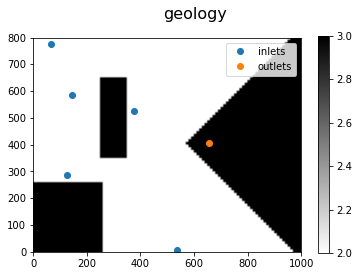

Iteration 0
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.009 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Iteration 1
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.008 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Iteration 2
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.009 s.
Field geodesicSolver defaults to Discrete
Field geodesicStep defaults to 0.25
Field geodesicWeightThreshold defaults to 0.001
Field geodesicVolumeBound defaults to 8.45
Iteration 3
Field verbosity defaults to 1
Field seedRadius defaults to 0
Fast marching solver completed in 0.007 s.
Field geodesicSolver defaults

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

<Figure size 720x720 with 0 Axes>

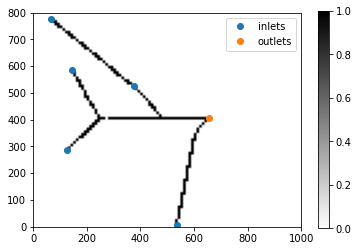

In [16]:
importlib.reload(pk)

catchment = pk.SKS("inputs/valley1/settings.yaml", rand_seed=1) #import settings and options from input folder
catchment.show_catchment(data='geology')
catchment.compute_karst_network()
#catchment.show()
catchment.show_hfm()

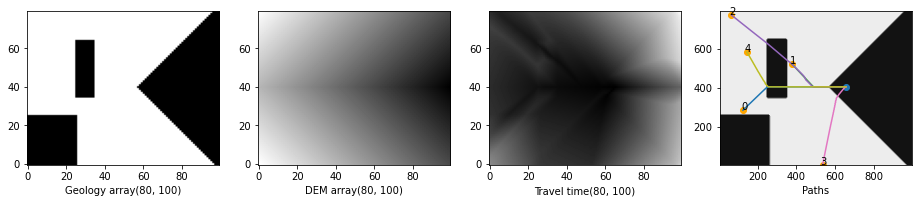

In [17]:
#Plot results:
f = plt.figure(figsize=(20,5))
f.add_subplot(151, aspect='equal')
plt.xlabel('Geology array'+str(catchment.geology.data['geology']['data'].shape))
plt.imshow(catchment.geology.data['geology']['data'], origin='lower', cmap='gray_r') #darker=faster

f.add_subplot(152, aspect='equal')
plt.xlabel('DEM array'+str(catchment.geology.data['topography']['data'].shape))
plt.imshow(catchment.geology.data['topography']['data'], origin='lower', cmap='gray') #darker=faster

f.add_subplot(153, aspect='equal')
plt.xlabel('Travel time'+str(catchment.fastMarchingOutput['values'].shape))
plt.imshow(catchment.fastMarchingOutput['values'], origin='lower', cmap='gray') 
#plt.contourf(catchment.grid.X,catchment.grid.Y, catchment.maps['phi']) #darker=faster

f.add_subplot(154, aspect='equal')
plt.xlabel('Paths')
plt.contourf(X,Y, catchment.maps['alpha'][0], cmap='gray_r')
plt.scatter(catchment.inlets_hfm[:,0],  catchment.inlets_hfm[:,1], c='orange')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1])
for i,inlet in enumerate(catchment.inlets_hfm):
    plt.annotate(str(i),(inlet[0]-10,inlet[1]))        #label active inlets in order of usage
for p,paths in enumerate(catchment.conduits_hfm):
    for path in paths:                                  #loop over paths (one per tip/starting point)
        pathX = path[1,:]                               #get list of X coord
        pathY = path[0,:]
        plt.plot(pathX,pathY, c=plt.cm.get_cmap('tab10')(p/len(inlets)))